In [1]:
%%capture
!pip install -q kaggle

In [ ]:
# Work With Files
import os

# Useful libraries:

from time import time
import numpy as np
import pandas as pd
import re
import json
import math
from functools import reduce

# To Plot:
import matplotlib.pyplot as plt
import seaborn as sns

# Pyspark Lib:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf

# Preprocess:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder,  OneHotEncoderEstimator, VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation

# Pysparl ML:
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder

from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
PATH_BUCKET = 'gs://nyc_comp_bk/'
PATH_MAIN = '/home/ubuntu/NYC_Taxi/'

In [4]:
os.chdir(PATH_MAIN)

In [5]:
class Work_On_Bucket():
    
    """
    This class makes possible the connectivity between Jupyter and GClood
    """
    
    def __init__(self, bucket_name):
        
        """
        Here is where the conenction is established, a new variable is created for the connected bucket
        
        Parameters
        ----------
        bucket_name : str
            The name of the Bucket with whom you want to communicate
            
        """
        
        # Get access to the bucket:
        storage_client = storage.Client()
        self.bucket = storage_client.get_bucket(bucket_name)
        
    def get_file_from_bucket(self, file_name, save_path, bucket_folder=''):
        
        """
        
        This function retrieves a file/folder from the connected bucket and save it locally on Jupyter
        
        Parameters
        ----------
        file_name : str
            The name of the file to get from the bucket
        save_path : str
            The path where to save the file on Jupyter
            (ex: /ubuntu/user/my_folder/)
            
        """
        
        # Download the file:
        blob = self.bucket.blob(bucket_folder+file_name)
        blob.download_to_filename(''.join([save_path, file_name]))
            
    def upload_file_to_bucket(self, file_name, folder_path, bucket_folder=''):
        
        """
        This function save a local Jupyter file to the connected Bucket
        
        Parameters
        ----------
        file_name : str
            The name of the file tosave
        folder_path : str
            The path where to find the file on the Bucket
        bucket_folder: str
            the folder where to save file in the Bucket
            
        """
        # Upload the File
        object_to_save = self.bucket.blob(bucket_folder+file_name)
        object_to_save.upload_from_filename(folder_path + file_name)


In [6]:
Bucket = Work_On_Bucket('nyc_comp_bk')

In [7]:
# Set kaggle:
! mkdir ~/.kaggle
Bucket.get_file_from_bucket('kaggle.json', PATH_MAIN)
! cp /home/ubuntu/NYC_Taxi/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
# Load Data:
data = spark.read.load(PATH_BUCKET+"train.csv", format="csv", inferSchema="true", header="true")
test = spark.read.load(PATH_BUCKET+"test.csv", format="csv", inferSchema="true", header="true")

# Load Test (Because pyspark changes the timestamp):
Bucket.get_file_from_bucket('test.csv', '')
original_test = pd.read_csv('test.csv')

In [9]:
# Remove Key, not needed:
data = data.drop('key')

In [10]:
# Remove Rows with Missing Values:
data = data.na.drop(how='any')

In [11]:
# Remove Duplicates:
data = data.distinct()

# EDA

In [12]:
# Write function to check if a point is a triangle:

def point_in_triangle(lat, long):
    
    """
    phuclv (https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle)
    To decide whether a point is in the triangle walk clockwise or counterclockwise around the triangle and 
    project the point onto the segment crossing by using the dot product. 
    Finally, check that the vector created is on the same side for each of the triangle's segments.
    
    Parameters
    ----------
    lat : float
        The latitude coordinate of a point
    long :float
        The longitude oordinate of a point

    Returns
    -------
    bool
        whether all signs of the sides are positive/negative
        
    """
    
    # Unpack arguments
    x = lat
    y = long
    ax, ay = (39.74274655286439, -75.26399018397262)
    bx, by = (41.58840050439113, -75.18708588709761)
    cx, cy = (41.07279488244855, -71.76484467616011)
    # Segment A to B
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    # Segment B to C
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    # Segment C to A
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)

def is_in_area(lat1, lon1, lat2, lon2):
    
    """
    
    Check whether both pick up and drop off points of an observation
    are in the triangle.
    
    Parameters
    ----------
    lat1 : float
        The latitude coordinate of a pick up point
    long1 :float
        The longitude oordinate of a pick up point
        
    lat2 : float
        The latitude coordinate of a drop off point
    long2 :float
        The longitude oordinate of a drop off point

    Returns
    -------
    bool
        whether both the points are in the hotspot
        
    """
    
    pick = point_in_triangle(lat1, lon1)
    drop = point_in_triangle(lat2, lon2)
    
    return all([pick, drop])

is_in_area_udf = F.udf(is_in_area, BooleanType())

In [13]:
# Remove any point outside the given area:
data = data.withColumn('keep', is_in_area_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') ))
data = data.filter("keep == True")
data = data.drop('keep')

In [ ]:
# Write Functions needed to Create Coordinates Features

class Coordinates_Transform():
    
    """

    This class allows to create new features exploting the latitude and longitude of the pickup and dropoff position

    Parameters
        ----------
        df : Pyspark Database
            The database to use to make the transformations

    """

    def __init__(self, df):

        self.df = df
        self.haversine_udf = F.udf(Coordinates_Transform.haversine_stat, DoubleType())
        self.direction_udf = F.udf(Coordinates_Transform.calculate_dir, DoubleType())


    @staticmethod
    def haversine_stat(pick_lat, drop_lat, pick_long, drop_long):

        """

        Compute the Haversine Distance

        Parameters
        ----------
        pick_lat : float
            The latitude coordinate of a pick up point
        pick_long :float
            The longitude oordinate of a pick up point

        drop_lat : float
            The latitude coordinate of a drop off point
        drop_long :float
            The longitude oordinate of a drop off point

        Returns
        -------
        float
            The Haversine Distance between the pick up point and the drop off one

        """

        # Transform in radians the coordinate:
        longit_a, latit_a, longit_b, latit_b = map(math.radians, [pick_long,  pick_lat, drop_long, drop_lat])

        # Compute the delta between both the coordinates:
        dist_longit = longit_b - longit_a
        dist_latit = latit_b - latit_a

        # Calculate area
        area = math.sin(dist_latit/2)**2 + math.cos(latit_a) * math.cos(latit_b) * math.sin(dist_longit/2)**2
        # Calculate the central angle
        central_angle = 2 * math.asin(math.sqrt(area))

        # Calculate Distance
        RADIUS = 6371
        distance = central_angle * RADIUS
        return round(distance, 3)

    def add_dist_metrics(self):

        """

        Compute Some distance metrics, such as: 
            - Absolute Distance 
            - Manahattan Distance
            - Euclidean Distance 
            - Haversine Distance.

        Returns
        -------
        Spark Database
            A Spark Databse containing the new features

        """

        # Absolute Lat e Long Distance:
        self.df = self.df.withColumn( 'abs_dist_longitude', F.round( F.abs( col('pickup_longitude') - col('dropoff_longitude') ) * 85, 3 ) )
        self.df = self.df.withColumn( 'abs_dist_latitude', F.round( F.abs( col('pickup_latitude') - col('dropoff_latitude') ) * 111 , 3 ) )
        self.df = self.df.withColumn( 'abs_dist_longitude_deg', F.round( F.abs( col('pickup_longitude') - col('dropoff_longitude') ), 3 ) )
        self.df = self.df.withColumn( 'abs_dist_latitude_deg', F.round( F.abs( col('pickup_latitude') - col('dropoff_latitude') ), 3 ) )

        # Manhattan Distance:
        self.df = self.df.withColumn( 'manhattan_dist', F.round( col('abs_dist_longitude') + col('abs_dist_latitude'), 3 ) )
        self.df = self.df.withColumn( 'manhattan_dist_deg', F.round( col('abs_dist_longitude_deg') + col('abs_dist_latitude_deg'), 3 ) )

        # Euclidean Distance:
        self.df = self.df.withColumn( 'euclidean_dist',  F.round( F.sqrt( col('abs_dist_longitude')**2 + col('abs_dist_latitude')**2 ), 3 ) )
        self.df = self.df.withColumn( 'euclidean_dist_deg',  F.round( F.sqrt( col('abs_dist_longitude_deg')**2 + col('abs_dist_latitude_deg')**2 ), 3 ) )
        # Haversine Distance:
        self.df = self.df.withColumn( 'haversine_dist', 
                                     self.haversine_udf( col('pickup_latitude'), col('dropoff_latitude'), col('pickup_longitude'), col('dropoff_longitude') ) ) 

        return self.df

    def distance_from_center(self):

        """

        It computes the haversine distance for both pickup and dropoff position from the city center
        which I choose to be Manhattan.

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one

        """

        MANHATTAN_LAT = F.lit(40.754932)
        MANHATTAN_LON = F.lit(-73.984016)

        self.df = self.df.withColumn( 'pickup_from_center', 
                                     self.haversine_udf( MANHATTAN_LAT, col('pickup_latitude'), MANHATTAN_LON, col('pickup_longitude') ) )
        self.df = self.df.withColumn( 'dropoff_from_center', 
                                     self.haversine_udf( MANHATTAN_LAT, col('dropoff_latitude'), MANHATTAN_LON, col('dropoff_longitude') ) )

        return self.df


    @staticmethod
    def calculate_dir(lat1, lon1, lat2, lon2):

        """

        https://www.movable-type.co.uk/scripts/latlong.html
        It is measured in 0 - 360 degrees

        Parameters
        ----------
        lat1 : float
            The latitude coordinate of a pick up point
        lon1 :float
            The longitude oordinate of a pick up point

        lat : float
            The latitude coordinate of a drop off point
        lon2 :float
            The longitude oordinate of a drop off point

        Returns
        -------
        float
            The computed degree between 0 and 360

        """

        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        theta = math.atan2(y, x)*180/math.pi

        return (-theta + 360) % 360



    def direction(self):

        """

        It executes the function to compute the degree on the database of the clas

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one

        """

        self.df = self.df.withColumn('direction', self.direction_udf( col('pickup_latitude'), col('pickup_longitude'), col('dropoff_latitude'), col('dropoff_longitude') )) \
                         .withColumn('haversine_dir', col('haversine_dist') * col('direction'))
        return self.df

    def third_dim_remap(self):

        """
        The credit for the next features goes to Jan van der Vegt @datascience.stackexchange.com
        https://datascience.stackexchange.com/users/14904/jan-van-der-vegt

        It recomputes the coordinates in 3D. It is useful to be more precise and when I am going to work with trees based models.

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one

        """

        # Compute coordinates for pickup:
        self.df = self.df.withColumn('pickup_x', F.cos('pickup_latitude') * F.cos('pickup_longitude'))
        self.df = self.df.withColumn('pickup_y', F.cos('pickup_latitude') * F.sin('pickup_longitude'))
        self.df = self.df.withColumn('pickup_z', F.sin('pickup_latitude'))

        # Compute coordinates for dropoff
        self.df = self.df.withColumn('dropoff_x', F.cos('dropoff_latitude') * F.cos('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_y', F.cos('dropoff_latitude') * F.sin('dropoff_longitude'))
        self.df = self.df.withColumn('dropoff_z', F.sin('dropoff_latitude'))

        return self.df

    def airports(self, threshold=2):

        """
        It computes some information about the airports: the distance from the pickup/dropoff position and each airport,
        given that metric, if the distance is less than 2km (my threshold) I create a categorical avriable that says 
        the name of the airport, instead the categorical has the value NO_AIRPORT. Finally, I had a simpler variable that 
        just says whther the position is close to an airpor tro not.

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one

        """

        # Set the coordinates of airports:
        JFK_LAT = 40.641766
        JFK_LON = -73.780968

        LGR_LAT = 40.773013
        LGR_LON = -73.870229

        EWR_LAT = 40.689531
        EWR_LON = -74.174462

        # Compute distance:
        self.df = self.df.withColumn('pickup_jfk_dist', self.haversine_udf(F.lit(JFK_LAT), col('pickup_latitude'), F.lit(JFK_LON), col('pickup_longitude')))
        self.df = self.df.withColumn('dropoff_jfk_dist', self.haversine_udf(F.lit(JFK_LAT), col('dropoff_latitude'), F.lit(JFK_LON), col('dropoff_longitude')))
        self.df = self.df.withColumn('pickup_lgr_dist', self.haversine_udf(F.lit(LGR_LAT), col('pickup_latitude'), F.lit(LGR_LON), col('pickup_longitude')))
        self.df = self.df.withColumn('dropoff_lgr_dist', self.haversine_udf(F.lit(LGR_LAT), col('dropoff_latitude'), F.lit(LGR_LON), col('dropoff_longitude')))
        self.df = self.df.withColumn('pickup_ewr_dist', self.haversine_udf(F.lit(EWR_LAT), col('pickup_latitude'), F.lit(EWR_LON), col('pickup_longitude')))
        self.df = self.df.withColumn('dropoff_ewr_dist', self.haversine_udf(F.lit(EWR_LAT), col('dropoff_latitude'), F.lit(EWR_LON), col('dropoff_longitude')))

        # Check which airport:
        self.df = self.df.withColumn( 'airport', F.when(col('pickup_jfk_dist') <= threshold, 'PICK_JFK')\
                                                        .when(col('dropoff_jfk_dist')<=threshold, 'DROP_JFK')\
                                                        .when(col('pickup_lgr_dist') <= threshold, 'PICK_LGR')\
                                                        .when(col('dropoff_lgr_dist') <= threshold, 'DROP_LGR')\
                                                        .when(col('pickup_ewr_dist') <= threshold, 'PICK_EWR')\
                                                        .when(col('dropoff_ewr_dist') <= threshold, 'DROP_EWR')\
                                                        .otherwise('NO_AIRPORT') )


        # Check whether whether is an airport or city:
        self.df = self.df.withColumn('airport_or_city', F.when(self.df.airport.contains('NO'), 'city')\
                .otherwise('airport'))

        # Combien Haversine and airport:
        self.df = self.df.withColumn('haversine_and_airport', col('haversine_dist')* F.when(col('airport_or_city')=='city', 0).otherwise(1))

        return self.df

    def long_short_trip(self):

        """
        It identifies whether a trip is longer or shorter than the avergare haversine distance.
        Possible improvments: use the mode or a value picked ad hoc from the distribution such as 7
        (the second improvment is also in terms of speed of computation).

        Returns
        -------
        Spark Databse
            A database containing all the older variables plus the new one

        """

        mean_len = self.df.select('haversine_dist').agg(F.mean(col('haversine_dist'))).first()[0]
        self.df = self.df.withColumn( 'long_short', F.when(col('haversine_dist') <= mean_len, 'short') \
                                     .otherwise('long') )
        return self.df



In [ ]:
# Add Distance metrics:
coordTransform = Coordinates_Transform(data)
data = coordTransform.add_dist_metrics()

In [ ]:

# Original Idea:
# Let's remove outlayers:
DIST_METRICS = ['manhattan_dist', 'euclidean_dist', 'haversine_dist']
n = len(DIST_METRICS)
row_mean  = (sum(col(x) for x in DIST_METRICS) / n).alias("mean_dist")
data = data.where( (row_mean >= 0.5) )
'''
# Last Test Idea:
data = data.filter( (col('abs_dist_longitude_deg') > 0) & (col('abs_dist_latitude_deg') > 0) )
'''

"\n# Last Test Idea:\ndata = data.filter( (col('abs_dist_longitude_deg') > 0) & (col('abs_dist_latitude_deg') > 0) )\n"

In [ ]:
# Add Directions:
data = coordTransform.direction()

In [ ]:
# Add third dimension:
data = coordTransform.third_dim_remap()

In [ ]:
# Let's Add when starting point or arrival is at the airport:
data = coordTransform.airports()

In [ ]:
# Add Pickup and Dropoff distance from the city center:
data = coordTransform.distance_from_center()

In [ ]:
# Add a binning for the length, based on the haversine distance:
data = coordTransform.long_short_trip()

In [ ]:
class Time_Transform():
    
    """
    
    This class extracts any interesting time features from the the pickup_datetime
    
    Parameters
        ----------
        df : Pyspark Database
            The database to use to make the transformations
        
    """

    def __init__(self, df):
        
        """
        
        Takes in input the databse to use and transformm the column pickup_datetime
        in the DateTime format to extract what I need
        
        """

        self.df = df.withColumn('pickup_datetime', F.substring(col('pickup_datetime'), 1, 19))\
        .withColumn('pickup_datetime', F.to_timestamp(col('pickup_datetime')))
        

    def get_date(self, remove_original=False):
        
        """
        
        It extracts all the basics information from the the datime,
        (such as: year, month, day of the week, day of the year, ...)
       
       Parameters
        ----------
        
        remove_original : bool
            if True it removes the pickup_datetime column

        Returns
        -------
        Spark Databse
            the old databse with the new variables
        
        """

        self.df = self.df.withColumn('year', F.year(col('pickup_datetime'))) \
        .withColumn('month', F.month(col('pickup_datetime'))) \
        .withColumn('week_of_year', F.weekofyear(col('pickup_datetime'))) \
        .withColumn('quarter', F.quarter(col('pickup_datetime')))\
        .withColumn('day_of_month', F.dayofmonth(col('pickup_datetime'))) \
        .withColumn('day_of_week', F.dayofweek(col('pickup_datetime'))) \
        .withColumn('day_of_year', F.dayofyear(col('pickup_datetime'))) \
        .withColumn('hour', F.hour(col('pickup_datetime'))) \
        .withColumn('minute', F.minute(col('pickup_datetime'))) \
        .withColumn('second', F.second(col('pickup_datetime')))

        if remove_original:
            self.df = self.df.drop('pickup_datetime')

        return self.df

    def is_weekend(self):
        
        """
        
        It creates a new column which identifaies whether the trip was in the weekend or not
        

        Returns
        -------
        Spark Database
            the old databse with the new variable
        
        """

        self.df = self.df.withColumn('is_week_end', F.when( (col('day_of_week')==6) | (col('day_of_week')==7), 'True' )\
                                    .otherwise('False'))
        return self.df


    def divide_day(self):
        
        """
        
        It creates a new column which identifaies in which part of the day the trip was done.
        

        Returns
        -------
        Spark Database
            the old databse with the new variable
        
        """

        self.df = self.df.withColumn('part_of_day', F.when(col('hour')>=20, 'overnight')\
                                     .when((col('hour')>=0) & (col('hour')<=6), 'overnight')\
                                     .when((col('hour')>6) & (col('hour')<=12), 'morning')\
                                     .when((col('hour')>12) & (col('hour')<16), 'afternoon')\
                                     .when((col('hour')>=16) & (col('hour')<20) & (col('is_week_end')=='False'), 'rush_hour')\
                                     .when((col('hour')>=16) & (col('hour')<20) & (col('is_week_end')=='True'), 'evening'))

        return self.df


    def add_fractions(self, remove_original=False, remove_cat=False):
        
        """
        
        It transforms some of the DateTime vatiables from Discrete to Continious using the idea of fraction of the whole.
        Ex. frac_of_day identifies in which fraction of day the race occurs: ( (race.hour + race.minute/60 + race.second/3600) / tot.hour )
        
        This approach works well in practice with non-linear models.
       
       Parameters
        ----------
        
        remove_original : bool
            if True it removes the pickup_datetime column
        remove_cat : bool
            if True it removes all the original variables extracted from pickup_datetime

        Returns
        -------
        Spark Databse
            the old databse with the new variables
        
        """

        self.df = self.df.withColumn('frac_of_day', ( col('hour') + col('minute')/60 + col('second')/3600 )/24 )\
        .withColumn('frac_of_week',  (col('day_of_week') + col('frac_of_day') )/7) \
        .withColumn('frac_of_month', ( col('day_of_month') + col('frac_of_day') ) / ( F.dayofmonth(F.last_day( col('pickup_datetime') ))+1 ) )\
        .withColumn('frac_of_year', ( col('day_of_year') + col('frac_of_day') )/(365 + 1) )     

        if remove_original:
            self.df = self.df.drop('pickup_datetime')
        if remove_cat:
            self.df = self.df.drop('month', 'week_of_year', 'quarter', 'day_of_month', 'day_of_week', 'day_of_year', 'hour',
                                   'minute', 'second')
        return self.df

    def cyclical_encoding(self, remove_original=False, remove_cat=False):
        
        """
        
        https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
        https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
        A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.
        We can do that using the following transformations:

        xsin=sin(2∗π∗x/max(x)) 
        xcos=cos(2∗π∗x/max(x))
        
        It is useful to transform discrete variables in continious ones. This encoding can be useful when work with linear model.
        (DON'T USE FOR NON LINEAR MODEL SUCH AS RANDOM FOREST AND DECISION TREES!)
        
        Parameters
        ----------
        
        remove_original : bool
            if True it removes the pickup_datetime column
        remove_cat : bool
            if True it removes all the original variables extracted from pickup_datetime

        Returns
        -------
        Spark Databse
            the old databse with the new variables
        
        """

        self.df = self.df.withColumn('month_sin', F.sin(col('month') * 2*math.pi / 12))\
        .withColumn('month_cos', F.cos(col('month') * 2*math.pi / 12))\
        .withColumn('week_of_year_sin', F.sin(col('week_of_year') * 2*math.pi / 52))\
        .withColumn('week_of_year_cos', F.cos(col('week_of_year') * 2*math.pi / 52))\
        .withColumn('quarter_sin', F.sin(col('quarter') * 2*math.pi / 4))\
        .withColumn('quarter_cos', F.cos(col('quarter') * 2*math.pi / 4))\
        .withColumn('day_of_month_sin', F.sin(col('day_of_month') * 2*math.pi / 31))\
        .withColumn('day_of_month_cos', F.cos(col('day_of_month') * 2*math.pi / 31))\
        .withColumn('day_of_week_sin', F.sin(col('day_of_week') * 2*math.pi / 7))\
        .withColumn('day_of_week_cos', F.cos(col('day_of_week') * 2*math.pi / 7))\
        .withColumn('day_of_yearh_sin', F.sin(col('day_of_year') * 2*math.pi / 366))\
        .withColumn('day_of_year_cos', F.cos(col('day_of_year' ) * 2*math.pi / 366))\
        .withColumn('hour_sin', F.sin(col('hour') * 2*math.pi / 24))\
        .withColumn('hour_cos', F.cos(col('hour') * 2*math.pi / 24))\
        .withColumn('minute_sin', F.sin(col('minute') * 2*math.pi / 60))\
        .withColumn('minute_cos', F.cos(col('minute') * 2*math.pi / 60))

        if remove_original:
            self.df = self.df.drop('pickup_datetime')
        if remove_cat:
            self.df = self.df.drop('month', 'week_of_year', 'quarter', 'day_of_month', 'day_of_week', 'day_of_year', 'hour',
                                   'minute', 'second')

        return self.df


In [ ]:
# Get daates basic info:
timeTransform = Time_Transform(data)
data = timeTransform.get_date()

In [ ]:
# Check if it is weekend:
data = timeTransform.is_weekend()

In [ ]:
# Check part of the day:
data = timeTransform.divide_day()

In [ ]:
# Transform Time to be used better in the models:
data = timeTransform.add_fractions()
data = timeTransform.cyclical_encoding(remove_cat=False, remove_original=True)

In [ ]:
# Clean Train:
data = data.filter('passenger_count > 0 AND passenger_count <=15')

In [ ]:
# FInd whch is a taxi and whoch a van
def taxi_or_van(df):
    
    """
        
    Dependning on the number of seats choose if the veicle is a taxi or a van if seats > 5 than Van.


    Parameters
    ----------

    df : Spark Database
        a spark database containg the columns I need
    Returns
    -------
    Spark Databse
        the old databse with the new variables
        
    """
    
    df = df.withColumn('taxi_or_van', F.when( (col('passenger_count') <= 6), 'taxi')\
                      .otherwise('van'))
    return df

In [ ]:
# Add taxi vs van variable to df:

data = taxi_or_van(data)

In [ ]:
# Remove Values lower than 2.50$:
data = data.filter('fare_amount > 2.50')

In [ ]:
# Remove Outlayers:
data = data.filter('fare_amount < 100')

In [ ]:
# Round to the third decimal:
data = data.withColumn('fare_amount', F.round('fare_amount', 3))

# Split and Test

In [33]:
train, validation = data.randomSplit(weights=[0.9999, 0.0001], seed=123)

In [ ]:
# Distance metrics:
coordTransformTest = Coordinates_Transform(test)
# Add Distances:
test = coordTransformTest.add_dist_metrics()
# Add Directions:
test = coordTransformTest.direction()
# Add third dimension:
test = coordTransformTest.third_dim_remap()
# Let's Add when starting point or arrival is at the airport:
test = coordTransformTest.airports()
# Add Pickup and Dropoff distance from the city center:
test = coordTransformTest.distance_from_center()
# Add a binning for the length, based on the haversine distance:
test = coordTransformTest.long_short_trip()

In [ ]:
# Time Metrics:
timeTransformTest = Time_Transform(test)
# Get daates basic info:
test = timeTransformTest.get_date()
# Check if it is weekend:
test = timeTransformTest.is_weekend()
# Check part of the day:
test = timeTransformTest.divide_day()
# Transform Time to be used better in the models:
test = timeTransformTest.add_fractions()
test = timeTransformTest.cyclical_encoding(remove_cat=False, remove_original=True)
# Taxi or Van feature:
test = taxi_or_van(test)

# Models

In [ ]:
class ModelUtils():
  
    '''
        
    This class provides some useful functions to plot correlation, feature importance and to work with the models.

   Parameters
    ----------
    numerical_features : list
        list of  names of the numerical varaibles that I want to include in the model
    categorical_features : list
        list of names of the categorical columns that I want to include in the model
    target : str
        the name of the target variable

    '''
  
    def __init__(self, numerical_features, categorical_features, target_variable):

        self.numerical =  numerical_features
        self.categorical = categorical_features
        self.target = target_variable
        
    @staticmethod
    def add_param(model_name, val, key1='', key2=''):
      
        """
        
        It allows to add any value to the any metrics json file

        Parameters
        ----------
        model_name : str
            the name of the model to modify params
        val : any
            the value to add or modify
        key1 : str
            the key of dict to add or modify
        key2 : str
            the sub-key of dict to add or modify

        """
        dbutils.fs.mv('dbfs:/'+ PATH_BUCKET + 'metrics/' + model_name + '.json', 'file:/' + PATH_MAIN + model_name + '_new' '.json')
        with open(model_name + '_new'+ '.json', 'r') as rf:
          read_f = json.load(rf)
          read_f['params'] = {}
          read_f['params'][key] = change
          with open(model_name+'.json', 'w') as wf:
            json.dump(read_f, wf)
        dbutils.fs.mv('file:/' + PATH_MAIN + model_name + '.json', 'dbfs:/'+PATH_BUCKET + 'metrics/' + model_name + '.json')
        dbutils.fs.rm('file:/' + PATH_MAIN + model_name + '_new' + '.json')
    
    
    def compute_labels(self, include_target, drop_last):
      
        """
        
        This function compute a list of all variables contained in the model, taking into account
        the pyspark OneHotEncode transformation.
        
        Parameters
        ----------
        include_target : bool
            if True the function include in the list the target variable
        drop_last : bool
            if True it means that the encoder drop the last category, so the function does so
              for each categoricla avriable included in the list.

        Returns
        -------
        A list containing all the names of the columns included in the model (considering the OneHoTEncoding)
        
        """
      
        dic = {
          'airport': sorted(['PICK_EWR','DROP_LGR','PICK_LGR','PICK_JFK','DROP_EWR','NO_AIRPORT','DROP_JFK']),
          'long_short': sorted(['False_long_short', 'True_long_short']),
          'part_of_day': sorted(['afternoon', 'overnight','rush_hour', 'morning','evening']),
          'taxi_or_van': sorted(['taxi', 'van']),
          'is_week_end': sorted(['False_is_week_end', 'True_is_week_end']),
          'airport_or_city': sorted(['airport', 'city']) 
        }

        cat_labs = []
        if drop_last:
            for col in self.categorical:
                cat_labs.extend(dic[col][:-1])
        else:
            for col in self.categorical:
                cat_labs.extend(dic[col])

        if include_target:
            return cat_labs + self.numerical + [self.target]
        else:
            return cat_labs + self.numerical
      
    
    
    def prepare_pipeline(self, encode, scale, drop_last, include_target, tree_based=False):
      
        """
        
        It configures different possible scenarios to add to a pipeline. It compute the pipline stages 
        and return a list with all of them.
        
        Parameters
        ----------
        encode : bool
            if True OneHotEncoding is performed
        scale : bool
            if True the variables are scaled
        drop_last : bool
            if True in OneHotEncoding the last category of each variable is dropped
        include_target : bool
            if True in all the operations also the taregt variable is included
              (useful when you need to compute correlation)

        Returns
        -------
        A list containing all the stages to execute in a Pipeline
        
        """
        if tree_based:
            indexers = [ StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col), handleInvalid="error", stringOrderType = 'alphabetAsc')
                        for col in self.categorical ]
            
            assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + self.numerical, outputCol="features")
            
            return indexers + [assembler]
          
        else: 
            # Both encode and scale:
            if all([encode, scale]):

                indexers = [ StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col), handleInvalid="error", stringOrderType = 'alphabetAsc')
                            for col in self.categorical ]
                encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
                                                   outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                                   handleInvalid="error", dropLast=drop_last)

                if include_target:
                    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + self.numerical + [self.target], outputCol="features")
                else:
                    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + self.numerical, outputCol="features")

                scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), 
                                              withStd=True, withMean=True)

                return indexers + [encoder, assembler, scaler]

            # Include encode but scaling
            elif encode and not scale:

                indexers = [ StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col), handleInvalid="error", stringOrderType = 'alphabetAsc')
                            for col in self.categorical ]
                encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
                                                   outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                                   handleInvalid="error", dropLast=drop_last)
                if include_target:
                    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + self.numerical + [self.target], outputCol="features")
                else:
                    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + self.numerical, outputCol="features")

                return indexers + [encoder, assembler]

            # Include Scale, but Encoding
            elif not encode and scale:

                if include_target:
                    assembler = VectorAssembler(inputCols=self.numerical + [self.target], outputCol="features")
                else:
                    assembler = VectorAssembler(inputCols=self.numerical, outputCol="features")

                scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), 
                                                  withStd=True, withMean=True)
                return [assembler, scaler]

            # No scaling, No encoding:
            elif not all([encode, scale]):

                if include_target:
                    assembler = VectorAssembler(inputCols=self.numerical + [self.target], outputCol="features")
                else:
                    assembler = VectorAssembler(inputCols=self.numerical, outputCol="features")

                return [assembler]
          
  
    def compute_correlation(self, method, df, include_target, size=(16, 10)):
      
        """
        
        It computes and plot the correlation matrix of a given set of variables
        
        Parameters
        ----------
        
        method : str
            The method to use to study correlation, Supported: pearson, spearman
        df : RDD
            the databse containing the variables
        include_target : bool
            if True it includes in the correlation matrix the target variable
        size : tuple
            A tuple containing the size of the plot

        Returns
        -------
        A plot of the correlation Matrix
        
        """
      
        # Compute the dataset:
        if self.categorical:
            pipe = self.prepare_pipeline(encode=True, scale=False, drop_last=False, include_target=True)
        else:
            pipe = self.prepare_pipeline(encode=False, scale=False, drop_last=False, include_target=True)
          
        pipeline = Pipeline(stages= pipe)
        transformer = pipeline.fit(df)
        my_df = transformer.transform(df)\
                .select('features')
       
      
        # Compute Correlation:
        corr_matr = Correlation.corr(my_df, 'features', 'pearson').collect()[0][0].toArray()
        labels = self.compute_labels(include_target=True, drop_last=False)
        corr_df = pd.DataFrame(corr_matr, columns = labels, index=labels)
        
        # Plot Correlation:
        mask = np.zeros_like(corr_matr)
        mask[np.triu_indices_from(mask, k=1)] = True
        
        plt.figure(figsize = size)
        sns.heatmap(corr_df, linewidths=.5, cmap = "RdBu_r", center = 0, annot = True, annot_kws={"fontsize":8}, mask=mask)
        plt.show()
        
    def pca_analysis(self, k, df, drop_last, analisis):
      
        """
        
        It performs the PCA Analysis and plot the cumulative explained variance
        
        Parameters
        ----------
        
        k : int
            number of components to compute
        df : RDD
            the databse containing the variables
        drop_last : bool
            if True it drop last category for each categorical variable
        analisis : bool
            If True performs the analysis and plot the cumulative explained var,
              otherwise it returns a pipeline including the pca

        Returns
        -------
        A plot with the explaine dvariance when analisis is true, when it is false it returns a pipeline
        including the PCA analysis.
        
        """
        
        # Prepare the pipeline:
        if self.categorical: 
            pipe = self.prepare_pipeline(encode=True, scale=True, drop_last=drop_last, include_target=False)
        else:
            pipe = self.prepare_pipeline(encode=False, scale=True, drop_last=drop_last, include_target=False)
        
        # Prepare the PCA:
        pca = PCA(k=k, inputCol='std_features', outputCol='pca_features')
        pipe.append(pca)
        
        
        if analisis:
            # Pipeline:
            pipeline = Pipeline(stages=pipe)
            transformer = pipeline.fit(df)
            explained_var = np.cumsum( transformer.stages[-1].explainedVariance.toArray() )
            explained_df = pd.DataFrame(explained_var, columns=['exp_var'])
            explained_df['labels'] = [i+1 for i in range(k)]
            explained_df.sort_values(by='labels', inplace=True)
            
            sns.lineplot(x='labels', y='exp_var', data=explained_df, markers=['o'], sort=True)
            plt.axhline(y=0.90, xmin=0, xmax=k, color='red', linestyle='--')
            plt.xticks([i for i in range(k)], ['PCA_' + str(i + 1) for i in range(k)], rotation=90)
            plt.show()
        else:
            return pipe
          
    def plot_importance(self, model, drop_last):
      
        """
        
        It performs the feature importance for tree based models
        
        Parameters
        ----------
        
        model : mlModel
            a fitted pyspark model
        drop_last : bool
            if True it drop last category for each categorical variable

        Returns
        -------
        A plot with the features importance
        
        """
        
        # Prepare Importance to be Plotted:
        labels = self.categorical + self.numerical
        to_df = list(zip(labels, model.stages[-1].featureImportances))
        df = pd.DataFrame(to_df, columns=['labels', 'importance'])
        df.sort_values(by='importance', inplace=True,  ascending=False)
        
        # Plot:
        plt.figure(figsize = (14,7))
        sns.barplot(x='importance', y='labels', data=df, orient='h', linewidth=1)
        plt.axvline(df['importance'].mean(), color='red', linestyle='--', linewidth=0.8)
        plt.title('Features importance', fontsize=20, pad=16)
        plt.show()
                    
            

In [ ]:
class RandomGridBuilder: 
    '''
    Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
    Distributions should be provided as lambda functions, so that the numbers are generated at call time.

    Credits: https://gist.github.com/SimenAlexanderLingeJohnsen/96b683cc67608d29ee1dc448818092f2

    Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)

    Returns:
    param_map: list of parameter maps to use in cross validation.

    Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()

    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
    def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
    def addDistr(self, param, distr_generator):
        '''
        Add distribution based on dictionary generated by function passed to addDistr.
        '''

        if 'pyspark.ml.param.Param' in str(type(param)):
            self._param_grid[param] = distr_generator
        else:
            raise TypeError('param must be an instance of Param')
        return self
  
    def build(self):    
        param_map = []
        for n in range(self.num_models):
            if self.seed:
                # Set seeds for both numpy and random in case either is used for the random distribution
                np.random.seed(self.seed + n)
                random.seed(self.seed + n)
            param_dict = {}
            for param, distr in self._param_grid.items():
                param_dict[param] = distr()
            param_map.append(param_dict)

        return param_map    

In [ ]:
class Models():
  
    """
    
    This class integrates some models offered by pyspark
    
    Parameters
    ----------

    train : RDD
        the training set
    validation : RDD
        the validtaion set
    test : RDD
        the validation set

    """
    
    def __init__(self, train, validation, test):
        
        self.train = train
        self.valid = validation
        self.test = test
        
    @staticmethod    
    def save_model(model, model_name):
        
        """
        
        It saves the model on the DBFS
        
        Parameters
        ----------
        
        model : mlModel
            a fitted model
        model_name : str
            the name which is used to save the model
        
        """
        
        model.bestModel.write().overwrite().save(PATH_BUCKET + model_name)
        
    @staticmethod      
    def load_model(model_name):
      
        """

        Load a model saved on the DBFS if it is present, otherwise return False

        Parameters
        ----------

        model_name : str
            the name that was used to save the model

        """
        
        try:
            return PipelineModel.load(PATH_BUCKET + model_name)
        except:
            return False
        
        
    def linear_regression_pipeline(self, numerical_features, categorical_features, target_variable, train_perc, n_parallel, 
                                   scale, intercept, drop_last, model_name, k_pca=None, n_search=1):
      
        """
        
        this function implement the linear regression pipeline
        
        Parameters
        ----------
        
        numerical_features : list
            list with the names of numerical features to include
        categorical_features : list
            list with the names of categorical features to include
        target_variable : str
            the name of the target variable
        train_perc : float
            the percentage of the dataset to use for the train
        n_parallel: int
            number of processes to compute in parallel
        scale : bool
            if True it scales the dataset
        intercept : bool
            if True it compute the linear model intercept
        drop_last : bool
            if True when OneHotEconde is performed drop last category of each variable
        model_name: str
            the name you want to assign to the model
        k_pca: int
            number of components to extract if you want to perform PCA

        Returns
        -------
        A fitted linear regressione Pipeline
        
        """
        
        # Check if model exists:
        model = Models.load_model(model_name)
        if model:
            self.model = model
        else:
        
            # Prepare Pipeline:
            utils = ModelUtils(numerical_features, categorical_features, target_variable)
            if k_pca:
                pipe = utils.pca_analysis(k_pca, self.train, drop_last, analisis=False)
            else:
                if categorical_features:
                    pipe = utils.prepare_pipeline(encode=True, scale=scale, drop_last=drop_last, include_target=False)
                else:
                    pipe = utils.prepare_pipeline(encode=False, scale=scale, drop_last=drop_last, include_target=False)

            # Prepare the linear Regression:
            if target_variable != "label":
                self.train = self.train.withColumnRenamed(target_variable, "label")

            if scale and not k_pca:
                lr = LinearRegression(featuresCol="std_features", labelCol="label", fitIntercept=intercept)
                pipeline = Pipeline(stages= pipe + [lr]) 
            elif k_pca:
                lr = LinearRegression(featuresCol="pca_features", labelCol="label", fitIntercept=intercept)
                pipeline = Pipeline(stages= pipe + [lr])  
            else:
                lr = LinearRegression(featuresCol="features", labelCol="label", fitIntercept=intercept)
                pipeline = Pipeline(stages= pipe + [lr])


            # HyperParamters Tuning:
            param_grid = RandomGridBuilder(n_search)\
              .addDistr(lr.regParam, lambda: np.random.choice([0.01, 0.001, 0.0001])) \
              .addDistr(lr.elasticNetParam, lambda: np.random.rand())\
              .build()

            tvs = TrainValidationSplit(estimator=pipeline,
                                     estimatorParamMaps=param_grid,
                                     evaluator=RegressionEvaluator(metricName="rmse"),
                                     trainRatio=train_perc,
                                     parallelism=n_parallel,
                                     collectSubModels=True,
                                     seed=123)


            # Run the model:
            self.model = tvs.fit(self.train)
            Models.save_model(self.model, model_name)

            # Compute and save metrics:
            self.compute_metrics(scale, model_name, drop_last, model_type='linear')

        return self.model
      
    def GBT_regressor_pipeline(self,numerical_features, categorical_features, target_variable, train_perc, n_parallel, 
                                   scale, drop_last, model_name, k_pca=None, n_search=1):
      
        """
        
        this function implement the linear regression pipeline
        
        Parameters
        ----------
        
        numerical_features : list
            list with the names of numerical features to include
        categorical_features : list
            list with the names of categorical features to include
        target_variable : str
            the name of the target variable
        train_perc : float
            the percentage of the dataset to use for the train
        n_parallel: int
            number of processes to compute in parallel
        scale : bool
            if True it scales the dataset
        drop_last : bool
            if True when OneHotEconde is performed drop last category of each variable
        model_name: str
            the name you want to assign to the model
        k_pca: int
            number of components to extract if you want to perform PCA

        Returns
        -------
        A fitted linear regressione Pipeline
        
        """
      
        # Check if model exists:
        model = Models.load_model(model_name)
        if model:
            self.model = model
        else:
        
            # Prepare Pipeline:
            utils = ModelUtils(numerical_features, categorical_features, target_variable)
            if k_pca:
                pipe = utils.pca_analysis(k_pca, self.train, drop_last, analisis=False)
            else:
                pipe = utils.prepare_pipeline(encode=False, scale=scale, drop_last=drop_last, 
                                              include_target=False, tree_based=True)

            # Prepare the linear Regression:

            if target_variable != "label":
                self.train = self.train.withColumnRenamed(target_variable, "label")


            if scale and not k_pca:
                gbt = GBTRegressor(featuresCol="std_features", labelCol="label", lossType='squared', 
                                   featureSubsetStrategy='onethird', seed=123)
                pipeline = Pipeline(stages= pipe + [gbt]) 
            elif k_pca:
                gbt = GBTRegressor(featuresCol="pca_features", labelCol="label", lossType='squared',
                                   featureSubsetStrategy='onethird',seed=123)
                pipeline = Pipeline(stages= pipe + [gbt])  
            else:
                gbt = GBTRegressor(featuresCol="features", labelCol="label", lossType='squared', 
                                    featureSubsetStrategy='onethird',seed=123)
                pipeline = Pipeline(stages= pipe + [gbt])


            # HyperParamters Tuning:
            param_grid = RandomGridBuilder(n_search)\
              .addDistr(gbt.maxDepth, lambda: np.random.randint(low=3, high=6, size=1, dtype=int)[0]) \
              .addDistr(gbt.minInstancesPerNode, lambda: np.random.randint(low=10, high=40, size=1, dtype=int)[0])\
              .addDistr(gbt.stepSize, lambda: np.random.choice(np.linspace(0.01,0.2,100)))\
              .build()

            tvs = TrainValidationSplit(estimator=pipeline,
                                     estimatorParamMaps=param_grid,
                                     evaluator=RegressionEvaluator(metricName="rmse"),
                                     trainRatio=train_perc,
                                     parallelism=n_parallel,
                                     collectSubModels=True,
                                     seed=123)

            # Run the model:
            self.model = tvs.fit(self.train)
            Models.save_model(self.model, model_name)

            # Compute and save metrics:
            self.compute_metrics(scale, model_name, drop_last, model_type='GBT')

        return self.model
      
    def RF_regressor_pipeline(self,numerical_features, categorical_features, target_variable, train_perc, n_parallel, 
                                   scale, drop_last, model_name, k_pca=None, n_search=1):
      
        """
        
        this function implement the linear regression pipeline
        
        Parameters
        ----------
        
        numerical_features : list
            list with the names of numerical features to include
        categorical_features : list
            list with the names of categorical features to include
        target_variable : str
            the name of the target variable
        train_perc : float
            the percentage of the dataset to use for the train
        n_parallel: int
            number of processes to compute in parallel
        scale : bool
            if True it scales the dataset
        drop_last : bool
            if True when OneHotEconde is performed drop last category of each variable
        model_name: str
            the name you want to assign to the model
        k_pca: int
            number of components to extract if you want to perform PCA

        Returns
        -------
        A fitted linear regressione Pipeline
        
        """
      
        # Check if model exists:
        model = Models.load_model(model_name)
        if model:
             self.model = model
        else:
        
            # Prepare Pipeline:
            utils = ModelUtils(numerical_features, categorical_features, target_variable)
            if k_pca:
                pipe = utils.pca_analysis(k_pca, self.train, drop_last, analisis=False)
            else:
                pipe = utils.prepare_pipeline(encode=False, scale=scale, drop_last=drop_last, 
                                              include_target=False, tree_based=True)

            # Prepare the linear Regression:

            if target_variable != "label":
                self.train = self.train.withColumnRenamed(target_variable, "label")


            if scale and not k_pca:
                rf = RandomForestRegressor(featuresCol="std_features", labelCol="label", featureSubsetStrategy='onethird', numTrees=100, seed=123)
                pipeline = Pipeline(stages= pipe + [rf]) 
            elif k_pca:
                rf = RandomForestRegressor(featuresCol="pca_features", labelCol="label", featureSubsetStrategy='onethird', numTrees=100, seed=123)
                pipeline = Pipeline(stages= pipe + [rf])  
            else:
                rf = RandomForestRegressor(featuresCol="features", labelCol="label", featureSubsetStrategy='onethird', numTrees=100, seed=123)
                pipeline = Pipeline(stages= pipe + [rf])


            # HyperParamters Tuning:
            param_grid = RandomGridBuilder(n_search) \
              .addDistr(rf.maxDepth, lambda: np.random.randint(low=3, high=6, size=1, dtype=int)[0]) \
              .addDistr(rf.minInstancesPerNode, lambda: np.random.randint(low=10, high=60, size=1, dtype=int)[0]) \
              .addDistr(rf.bootstrap, lambda: bool(np.random.choice([True, False])))\
              .build()

            tvs = TrainValidationSplit(estimator=pipeline,
                                     estimatorParamMaps=param_grid,
                                     evaluator=RegressionEvaluator(metricName="rmse"),
                                     trainRatio=train_perc,
                                     parallelism=n_parallel,
                                     collectSubModels=True,
                                     seed=123)

            # Run the model:
            self.model = tvs.fit(self.train)

            Models.save_model(self.model, model_name)


            # Compute and save metrics:
            self.compute_metrics(scale, model_name, drop_last, model_type='RF')

        return self.model

        
    def compute_adj_r2(self, r2, scale, is_train):
      
        """
        
        This function compute the Adjusted R squared
        adjR = 1 - ((1 - R2)*(n - 1) / (n - p -1))
        where n = tot observation
        and p = number of features
        
        Parameters
        ----------
        
        r2 : float
            the value of the r squared
        scale : bool
            whether the databse used was scaled or not
        is_train: bool
            If True it uses the training set, otherwise the validation set
        Returns
        -------
        The adjuste R2 value
        
        """
        
        if is_train:
            if scale:
                n_features = self.model.transform(self.train).select('std_features').first()[0].size
                n_obs = self.train.count()
                adj_r2 = 1 - ( ( (1 - r2) * (n_obs - 1) ) / ( n_obs - n_features - 1 ) )
            else:
                n_features = self.model.transform(self.train).select('features').first()[0].size
                n_obs = self.train.count()
                adj_r2 = 1 - ( ( (1 - r2) * (n_obs - 1) ) / ( n_obs - n_features - 1 ) )
        else:
            if scale:
                n_features = self.model.transform(self.valid).select('std_features').first()[0].size
                n_obs = self.valid.count()
                adj_r2 = 1 - ( ( (1 - r2) * (n_obs - 1) ) / ( n_obs - n_features - 1 ) )
            else:
                n_features = self.model.transform(self.valid).select('features').first()[0].size
                n_obs = self.valid.count()
                adj_r2 = 1 - ( ( (1 - r2) * (n_obs - 1) ) / ( n_obs - n_features - 1 ) )
            
            
        return adj_r2
    
    def evaluate_model(self, predictions, metric):
      
        """
        
        This function evaluate a the model given a metric
        
        Parameters
        ----------
        
        predictions : RDD
            a pyspark databse contianing the predictions
        metric : str
            the metric to use for the evaluate, Supported: rmse, R2, mae
        

        Returns
        -------
        The given metric (rmse, mae, R2)
        
        """
    
        evaluator = RegressionEvaluator(labelCol="label",
                                        predictionCol="prediction",
                                        metricName=metric)

        return evaluator.evaluate(predictions)
    
    def compute_metrics(self, scale, model_name, drop_last, model_type):
      
        """
        
        This Function compute the metrics for the model and save to a json file
        
        Parameters
        ----------
        
        scale : bool
            if True the model used was scaled
        model_name : str
            the name of the model for which you are computing the metrics
        drop_last : bool
            if True when OneHotEconde is performed drop last category of each variable
        model_type: str
            the type of model, Supported: linear, GBT

        Returns
        -------
        Save a JSON file with the computed parameters
        
        """
        
        if model_type=='linear':
            
            # Get summaries
            training_result = self.model.bestModel.stages[-1].summary
            # Compute Train Metrics:
            rmse_train = training_result.rootMeanSquaredError
            r2_train = training_result.r2
            adj_r2_train = self.compute_adj_r2(r2_train,scale=scale,is_train=True)

            # Compute Validation Metrics:
            self.valid = self.valid.withColumnRenamed("fare_amount", "label")
            predictions = self.model.transform(self.valid)

            rmse_valid = self.evaluate_model(predictions, 'rmse')
            r2_valid = self.evaluate_model(predictions, 'r2')
            adj_r2_valid = self.compute_adj_r2(r2_valid, scale=scale, is_train=False)


            # Save Metrics in A dcit:
            metrics = {
                'train':{
                    'rmse': rmse_train,
                    'R2': r2_train,
                    'adj_R2': adj_r2_train     
                },
                'valid': {
                    'rmse': rmse_valid,
                    'R2': r2_valid,
                    'adj_R2': adj_r2_valid
                },
                'params': {
                  'drop_last': drop_last
                }
            }
            
        elif model_type=='GBT' or model_type=='RF':


            # Compute Validation Metrics:
            self.valid = self.valid.withColumnRenamed("fare_amount", "label")
            predictions = self.model.transform(self.valid)

            rmse_valid = self.evaluate_model(predictions, 'rmse')
            r2_valid = self.evaluate_model(predictions, 'r2')
            adj_r2_valid = self.compute_adj_r2(r2_valid, scale=scale, is_train=False)


            # Save Metrics in A dcit:
            metrics = {
                
                'valid': {
                    'rmse': rmse_valid,
                    'R2': r2_valid,
                    'adj_R2': adj_r2_valid
                },
                'params': {
                  'drop_last': drop_last
                }
            }
                                                                         
        
        # Save Metrics:
         with open(PATH_MAIN +  model_name + '.json', 'w') as f:
            json.dump(metrics, f)
        Bucket.upload_file_to_bucket(model_name +'.json', PATH_MAIN, 'metrics/')
        
    @staticmethod     
    def training_results(model_name, model_type, numerical_features, categorical_features):
      
        """
        
        this function load the json file with the metrics and plot them
        
        Parameters
        ----------
        
        
        model_name : str
            the name of the model for which you are computing the metrics
        model_type: str
            the type of model, Supported: linear, GBT
        numerical_features : list
            list of names of numerical columns included in the model
        categorical_features : list
            list of names of categorical columns included in the model

        Returns
        -------
        Print the metrics
        
        """
      
        # Load Model and Json:
        regressor = Models.load_model(model_name)
                        
        Bucket.get_file_from_bucket(model_name + '.json', PATH_MAIN, 'metrics/')
        file = open(PATH_MAIN + model_name + '.json', 'r')
        metrics = json.load(file)
        drop_last=metrics['params']['drop_last']
        file.close()
        
        if model_type == 'linear':  
          
            # Create Labels:
            utils = ModelUtils(numerical_features, categorical_features, '')
            labels =  utils.compute_labels(include_target=False, drop_last=drop_last) 
            
            # Print HyperParams:
            print("***** Hyper Parameters *****")
            print('regParam: ' + re.search(r'(?<=nt:\s)(\d+.\d+)', regressor.stages[-1].explainParam('regParam')).group(0))
            print('elasticNetParam: ' + re.search(r'(?<=nt:\s)(\d+.\d+)', regressor.stages[-1].explainParam('elasticNetParam')).group(0))
            print("***** Hyper Parameters *****\n")
            
            # Print coeffcients:
            intercept = regressor.stages[-1].intercept
            coeff = [intercept] + list(regressor.stages[-1].coefficients)
            coeff_names = ['Intercept'] + labels
          
            
            print("***** Parameters *****")
            print ("Feature       |  Coefficients          ")
            for i in range(len(coeff)):
                print ('{}: '.format(coeff_names[i]),\
                       '{:10.4f}'.format(coeff[i]))
            print("***** Parameters *****\n")
            
            # Print Metrics:
            print("***** Training Metrics *****")
            for k, v in metrics['train'].items():
                print("{}: {:.3f}".format(str(k), v))
            print("***** Training Metrics *****\n")

            print("***** Validation Metrics *****")
            for k, v in metrics['valid'].items():
                print("{}: {:.3f}".format(str(k), v))
            print("***** Validation Metrics *****\n")
            
        elif model_type == 'GBT':
          
            # Print HyperParams:
            print("***** Hyper Parameters *****")
            print('stepSize: ' + str(regressor.stages[-1]._java_obj.getStepSize()))
            print('minInstancesPerNode: ' + str(regressor.stages[-1]._java_obj.getMinInstancesPerNode()))
            print('maxDepth: ' + str(regressor.stages[-1]._java_obj.getMaxDepth()))
            print("***** Hyper Parameters *****\n")

            # Print Metrics:
            print("***** Validation Metrics *****")
            for k, v in metrics['valid'].items():
                print("{}: {:.3f}".format(str(k), v))
            print("***** Validation Metrics *****\n")
            
            # Print Importance
            utils = ModelUtils(numerical_features, categorical_features, '')
            utils.plot_importance(regressor, drop_last)
            
        elif model_type == 'RF':
          
            # Print HyperParams:
            print("***** Hyper Parameters *****")
            print('bootstrap: ' + str(regressor.stages[-1]._java_obj.getBootstrap()))
            print('minInstancesPerNode: ' + str(regressor.stages[-1]._java_obj.getMinInstancesPerNode()))
            print('maxDepth: ' + str(regressor.stages[-1]._java_obj.getMaxDepth()))
            print("***** Hyper Parameters *****\n")

            # Print Metrics:
            print("***** Validation Metrics *****")
            for k, v in metrics['valid'].items():
                print("{}: {:.3f}".format(str(k), v))
            print("***** Validation Metrics *****\n")
            
            # Print Importance
            utils = ModelUtils(numerical_features, categorical_features, '')
            utils.plot_importance(regressor, drop_last)

            
    def prepare_submission(self, original_test, model_name=''):
        
        """
        
        this function prepare the csv for the submission
        
        Parameters
        ----------
        original_test : pandas DataFrame
            the test dataset 
        model_name: str
            the name with whom the model was saved

        Returns
        -------
        A csv ready for the submission
        
        """
        
        
        # Make the predictions:
        if not model_name:
            predictions = self.model.transform(self.test).select('prediction').withColumnRenamed('prediction','fare_amount').toPandas()
        else:
            regressor = Models.load_model(model_name)
            predictions = regressor.transform(self.test).select('prediction').withColumnRenamed('prediction','fare_amount').toPandas()
            
        # Prepare the Submission:
        submission = pd.concat([original_test['key'], predictions['fare_amount']], axis=1)
        submission.to_csv('/'+PATH_MAIN + 'submission.csv', index=False)
        
    @staticmethod
    def return_predictions_ensemble_df(in_df, original_test, models, type):
      
        """
        
        this function load multiple models and prepare a dataframe with their predictions
        
        Parameters
        ----------
        test : RDS
            the test dataset 
        model: list
            a list of models to load
        type : str
            to say which kind of df to return. Supported: valid, test

        Returns
        -------
        A Pandas DataFrame with the prediction of the models
        
        """
        
        #Prepare Vlaid:
        in_df = in_df.withColumnRenamed("fare_amount", "label")
        # Define the Dataframe:
        model = Models.load_model(models[0])
        if type=='valid':
            df = model.transform(in_df).select('label','prediction').toPandas()
            name = re.search(r'(linear|GBT|RF)', models[0]).group(0)
            df.columns = ['actual', 'prediction_' + name]
        else: 

            df = model.transform(in_df).select('prediction').toPandas()
            name = re.search(r'(linear|GBT|RF)', models[0]).group(0)
            df.columns = ['prediction_' + name]
            
        
        n = len(models)
        for i in range(1, n):
            model = Models.load_model(models[i])
            new_df =  model.transform(in_df).select('prediction').toPandas()
            name = re.search(r'(linear|GBT|RF)', models[i]).group(0)
            new_df.columns = ['prediction_'+name]
            df = pd.concat([df, new_df], axis=1)
        
        if type=='test':
         
            df['fare_amount'] = df.mean(axis=1)
            df = pd.concat([original_test['key'], df['fare_amount']], axis=1)
            return df
        else:
            return df

# Execution:

In [ ]:
MyModel = Models(train, validation, test)

In [ ]:
# First approach all basics:
NUMERICAL = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'passenger_count']
CATEGORICAL = []
TARGET = 'fare_amount'

In [ ]:
# LINEAR MODEL:
MyModel.linear_regression_pipeline(NUMERICAL, CATEGORICAL, TARGET, train_perc=0.90, n_parallel=2, scale=True, intercept=True, drop_last=False,
                                   model_name='linear_basic_features')
# Print Anything about the model:
Models.training_results(model_name='linear_basic_features', model_type='linear',
                        numerical_features=NUMERICAL, categorical_features=CATEGORICAL)

# Prepare the submission:
MyModel.prepare_submission(original_test=original_test)

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f /databricks/driver/submission.csv -m "Linear_Basic_Features"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction

In [ ]:
# GBT MODEL:
MyModel.GBT_regressor_pipeline(NUMERICAL, CATEGORICAL, TARGET, train_perc=0.90, n_parallel=2, scale=True, drop_last=False,
                                   model_name='GBT_all_features')
# Print Anything about the model:
Models.training_results(model_name='GBT_all_features', model_type='GBT',
                        numerical_features=NUMERICAL, categorical_features=CATEGORICAL)

# Prepare the submission:
MyModel.prepare_submission(original_test=original_test)

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f /databricks/driver/submission.csv -m "GBT_all_features"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction

/databricks/spark/python/pyspark/ml/util.py:846: UserWarning: MLlib could not reach the MLflow server at tracking URI: databricks
Exception: You haven't configured the CLI yet! Please configure by entering `/databricks/python_shell/scripts/db_ipykernel_launcher.py configure`
 warnings.warn(

***** Hyper Parameters *****
bootstrap: True
minInstancesPerNode: 21
maxDepth: 4
***** Hyper Parameters *****

***** Validation Metrics *****
rmse: 4.225
R2: 0.794
adj_R2: 0.794
***** Validation Metrics *****

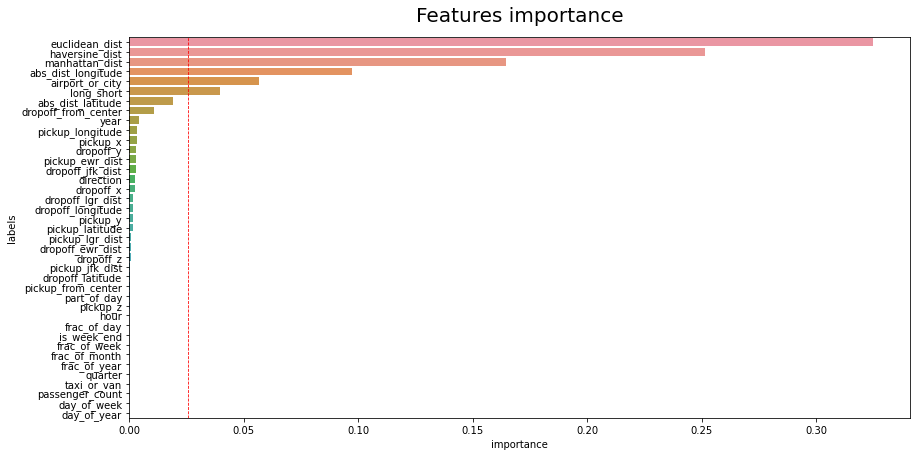

0%| | 0.00/453k [00:00<?, ?B/s]

100%|█████████████████████████████████████████| 453k/453k [00:01<00:00, 235kB/s]

Successfully submitted to New York City Taxi Fare Prediction

fileName date description status publicScore privateScore 
-------------- ------------------- ---------------------------------------- -------- ----------- ------------ 
submission.csv 2021-09-11 20:52:56 RF_all_indexed complete 4.13803 4.13803 
submission.csv 2021-09-11 19:30:58 ensemble complete 3.71246 3.71246 
submission.csv 2021-09-11 19:26:46 GBT_features_indexed_reduce_3D complete 3.73946 3.73946 
submission.csv 2021-09-11 18:12:33 GBT_features_indexed_reduce_3 complete 3.63770 3.63770 
submission.csv 2021-09-11 17:31:15 GBT_features_indexed_reduce_2 complete 3.67108 3.67108 
submission.csv 2021-09-11 15:40:34 GBT_features_indexed_reduce_1 complete 3.64460 3.64460 
submission.csv 2021-09-11 14:49:38 GBT_all_features_indexed complete 3.71947 3.71947 
submission.csv 2021-09-11 13:39:39 RF_best_not_encoded complete 4.13631 4.13631 
submission.csv 2021-09-10 21:08:57 ensemble complete 3.74579 3.74579 
submission.csv 2021-09-10 20:54:02 ensemble error None None 
submission.csv 2021-09-10 20:32:01 Linear_new_features complete 4.13055 4.13055 
submission.csv 2021-09-10 16:10:27 GBT_less_features_not_scaled complete 3.74897 3.74897 
submission.csv 2021-09-10 15:33:23 RF_best_not_scaled complete 3.96042 3.96042 
submission.csv 2021-09-10 14:57:10 RF_reduce_3 complete 4.15932 4.15932 
submission.csv 2021-09-10 14:16:58 RF_reduce_2 complete 3.96845 3.96845 
submission.csv 2021-09-10 13:29:11 RF_reduce_1 complete 3.95235 3.95235 
submission.csv 2021-09-10 12:39:00 RF_reduce_cat complete 3.96894 3.96894 
submission.csv 2021-09-10 11:41:56 RF_full complete 3.95212 3.95212 
submission.csv 2021-09-10 10:20:46 RF_best_model_xgboost complete 3.97462 3.97462 
submission.csv 2021-09-10 08:56:22 GBT_PCA complete 4.59536 4.59536 
submission.csv 2021-09-09 22:52:54 GBT_less_features_from_best complete 3.78034 3.78034 
submission.csv 2021-09-09 22:03:17 GBT_all_features_tuned complete 4.01581 4.01581 
submission.csv 2021-09-09 21:45:34 GBT_all_features_tuned complete 4.01581 4.01581 
submission.csv 2021-09-09 21:42:32 GBT_all_features_tuned complete 4.01581 4.01581 
submission.csv 2021-09-09 20:31:43 Linear_new_features_original_time complete 4.17854 4.17854 
submission.csv 2021-09-09 19:39:48 Linear_basic_coord_new_features complete 5.09752 5.09752 
submission.csv 2021-09-09 17:57:52 Linear_new_features_airport_dist complete 4.52315 4.52315 
submission.csv 2021-09-09 16:58:45 Linear_new_features_adjust complete 4.12528 4.12528 
submission.csv 2021-09-09 14:39:15 Linear_all_y complete 4.17026 4.17026 
submission.csv 2021-09-09 13:38:07 Linear_new_features complete 4.11191 4.11191 
submission.csv 2021-09-08 23:30:27 Linear_new_features complete 4.06430 4.06430 
submission.csv 2021-09-08 12:57:42 GBT_combo_more_obs complete 4.28409 4.28409 
submission.csv 2021-09-08 11:53:29 GBT_combo complete 4.28205 4.28205 
submission.csv 2021-09-08 11:09:02 GBT_airport_distance complete 4.35193 4.35193 
submission.csv 2021-09-08 10:16:38 GBT_original_time complete 4.30898 4.30898 
submission.csv 2021-09-08 09:30:59 GBT_new_airport_center_dist complete 4.30653 4.30653 
submission.csv 2021-09-07 23:25:29 GBT_new_airport complete 4.46207 4.46207 
submission.csv 2021-09-07 22:29:35 GBT_dist_frac complete 4.37149 4.37149 
submission.csv 2021-09-07 21:45:07 GBT_no_zero_importance complete 5.64505 5.64505 
submission.csv 2021-09-07 20:29:29 GBT_all_features complete 4.12778 4.12778 
submission.csv 2021-09-06 00:22:41 Linear_PCA complete 4.91455 4.91455 
submission.csv 2021-09-04 17:44:56 All_varibles complete 4.16247 4.16247 
submission.csv 2021-09-04 15:44:39 Linear_dist_time_original complete 4.10160 4.10160 
submission.csv 2021-09-04 13:25:44 Linear_dist_time_original complete 4.10160 4.10160 
submission.csv 2021-09-04 12:08:02 linear_dist_time_day_of_week complete 4.09506 4.09506 
submission.csv 2021-09-04 10:52:03 linear_dist_time_day_of_month complete 4.10080 4.10080 
submission.csv 2021-09-03 23:40:35 Linear_al

In [ ]:
# Compute the model:
MyModel.RF_regressor_pipeline(NUMERICAL, CATEGORICAL, TARGET, train_perc=0.90, n_parallel=2, scale=False, drop_last=False,
                                   model_name='RF_all_indexed', n_search=2)
# Print Anything about the model:
Models.training_results(model_name='RF_all_indexed', model_type='RF',
                        numerical_features=NUMERICAL, categorical_features=CATEGORICAL)

# Prepare the submission:
MyModel.prepare_submission(original_test=original_test)

# Submit:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f /databricks/driver/submission.csv -m "RF_all_indexed"
!kaggle competitions submissions -c new-york-city-taxi-fare-prediction